# 2.0 Train model and save the results

Setup

In [30]:
import torch

In [31]:
device = torch.device("cuda") if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

print(f"Using device: {device}")

Using device: cuda


## Prepare data

Define dataset parameters and transforms

In [32]:
from torchvision import transforms

# train_mean = [0.3186241388320923, 0.2931755483150482, 0.3017965853214264]
# train_std = [0.2762017846107483, 0.2654302418231964, 0.2686000168323517]

train_mean = [0.5, 0.5, 0.5]
train_std = [0.5, 0.5, 0.5]


class ContrastStretch(object):
    def __call__(self, img):
        # img: Tensor [C,H,W] in [0,1]
        lo, hi = img.min(), img.max()
        return (img - lo) / (hi - lo + 1e-5)

transform = transforms.Compose([
    transforms.ToTensor(),
    ContrastStretch(),
    transforms.Normalize(mean=train_mean, std=train_std),
])

Load the dataset

In [33]:
from torchvision.datasets import ImageFolder

# train_dir = "./data/train_upsampled"
train_dir = "./data/train"
train_ds = ImageFolder(train_dir, transform=transform)

num_classes = len(train_ds.classes)

print(f"Number of train images: {len(train_ds)}")
print(f"Number of train classes: {num_classes}")

Number of train images: 31367
Number of train classes: 43


Prepare data loaders

In [34]:
from torch.utils.data import DataLoader

batch_size = 256

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

Add weighted loader

In [35]:
import numpy as np
from torch.utils.data import DataLoader, WeightedRandomSampler
from collections import Counter

targets = train_ds.targets 
class_counts = Counter(targets)
num_samples = len(targets)

class_weights = {cls: max(count, 1000) for cls, count in class_counts.items()}

sample_weights = np.array([class_weights[t] for t in targets], dtype=np.float32)

sampler = WeightedRandomSampler(
    weights=sample_weights,     
    num_samples=int(num_samples * 1.5),  # oversample
    replacement=True
)

rebalanced_train_dl = DataLoader(
    train_ds,
    batch_size=batch_size,
    sampler=sampler,
    shuffle=True,
)

ValueError: sampler option is mutually exclusive with shuffle

## Create model

Define the latent space

In [ ]:
latent_dim = 128

Define the model

In [ ]:
from gnn import Generator, Discriminator

generator = Generator(num_classes, latent_dim=latent_dim).to(device)
discriminator = Discriminator(num_classes).to(device)

## Train model

Initialize weights

In [ ]:
# import torch.nn as nn

# def weights_init_normal(m):
#     classname = m.__class__.__name__
#     if classname.find('Conv') != -1 or classname.find('Linear') != -1:
#         nn.init.normal_(m.weight.data, 0.0, 0.02)
#         if m.bias is not None:
#             nn.init.constant_(m.bias.data, 0)
#     elif classname.find('BatchNorm2d') != -1:
#         # gamma ≈ 1.0, β = 0
#         nn.init.normal_(m.weight.data, 1.0, 0.02)
#         nn.init.constant_(m.bias.data, 0)


# generator.apply(weights_init_normal)
# discriminator.apply(weights_init_normal)

Define training parameters

In [ ]:
import torch.optim as optim
import torch.nn as nn

G_lr = 1e-4
D_lr = 1e-4

# Optimizers
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=G_lr)
generator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=generator_optimizer, gamma=0.99)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=D_lr)
discriminator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=discriminator_optimizer, gamma=0.99)

# loss
adv_criterion = nn.BCEWithLogitsLoss()

Train the model

Epoch 1: 100%|██████████| 184/184 [01:05<00:00,  2.79it/s]


Epoch 1: D(real)=0.754  D(fake)=0.259  D_loss=120.214  G_loss=194.353


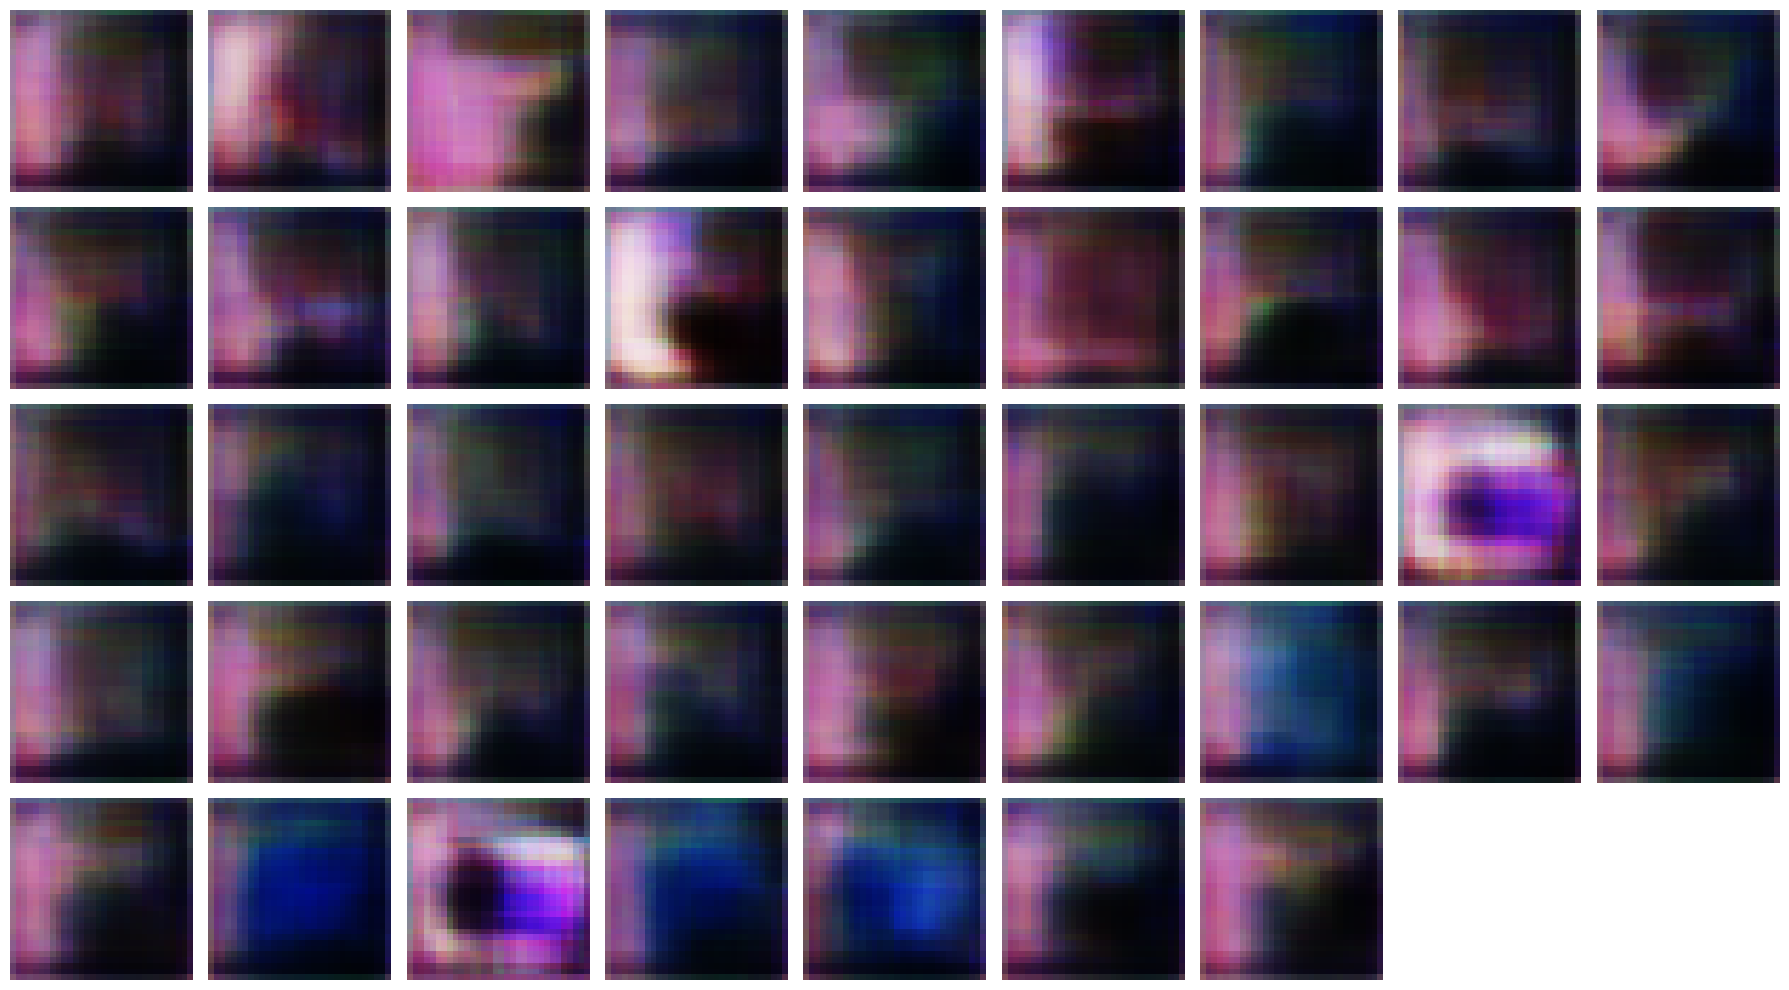

Epoch 2: 100%|██████████| 184/184 [01:07<00:00,  2.74it/s]


Epoch 2: D(real)=0.789  D(fake)=0.217  D_loss=50.807  G_loss=104.154


Epoch 3: 100%|██████████| 184/184 [01:07<00:00,  2.72it/s]


Epoch 3: D(real)=0.831  D(fake)=0.174  D_loss=20.897  G_loss=89.391


Epoch 4: 100%|██████████| 184/184 [01:07<00:00,  2.72it/s]


Epoch 4: D(real)=0.817  D(fake)=0.179  D_loss=25.930  G_loss=96.514


Epoch 5: 100%|██████████| 184/184 [01:07<00:00,  2.74it/s]


Epoch 5: D(real)=0.871  D(fake)=0.134  D_loss=13.015  G_loss=90.257


Epoch 6: 100%|██████████| 184/184 [01:07<00:00,  2.74it/s]


Epoch 6: D(real)=0.899  D(fake)=0.100  D_loss=10.299  G_loss=112.492


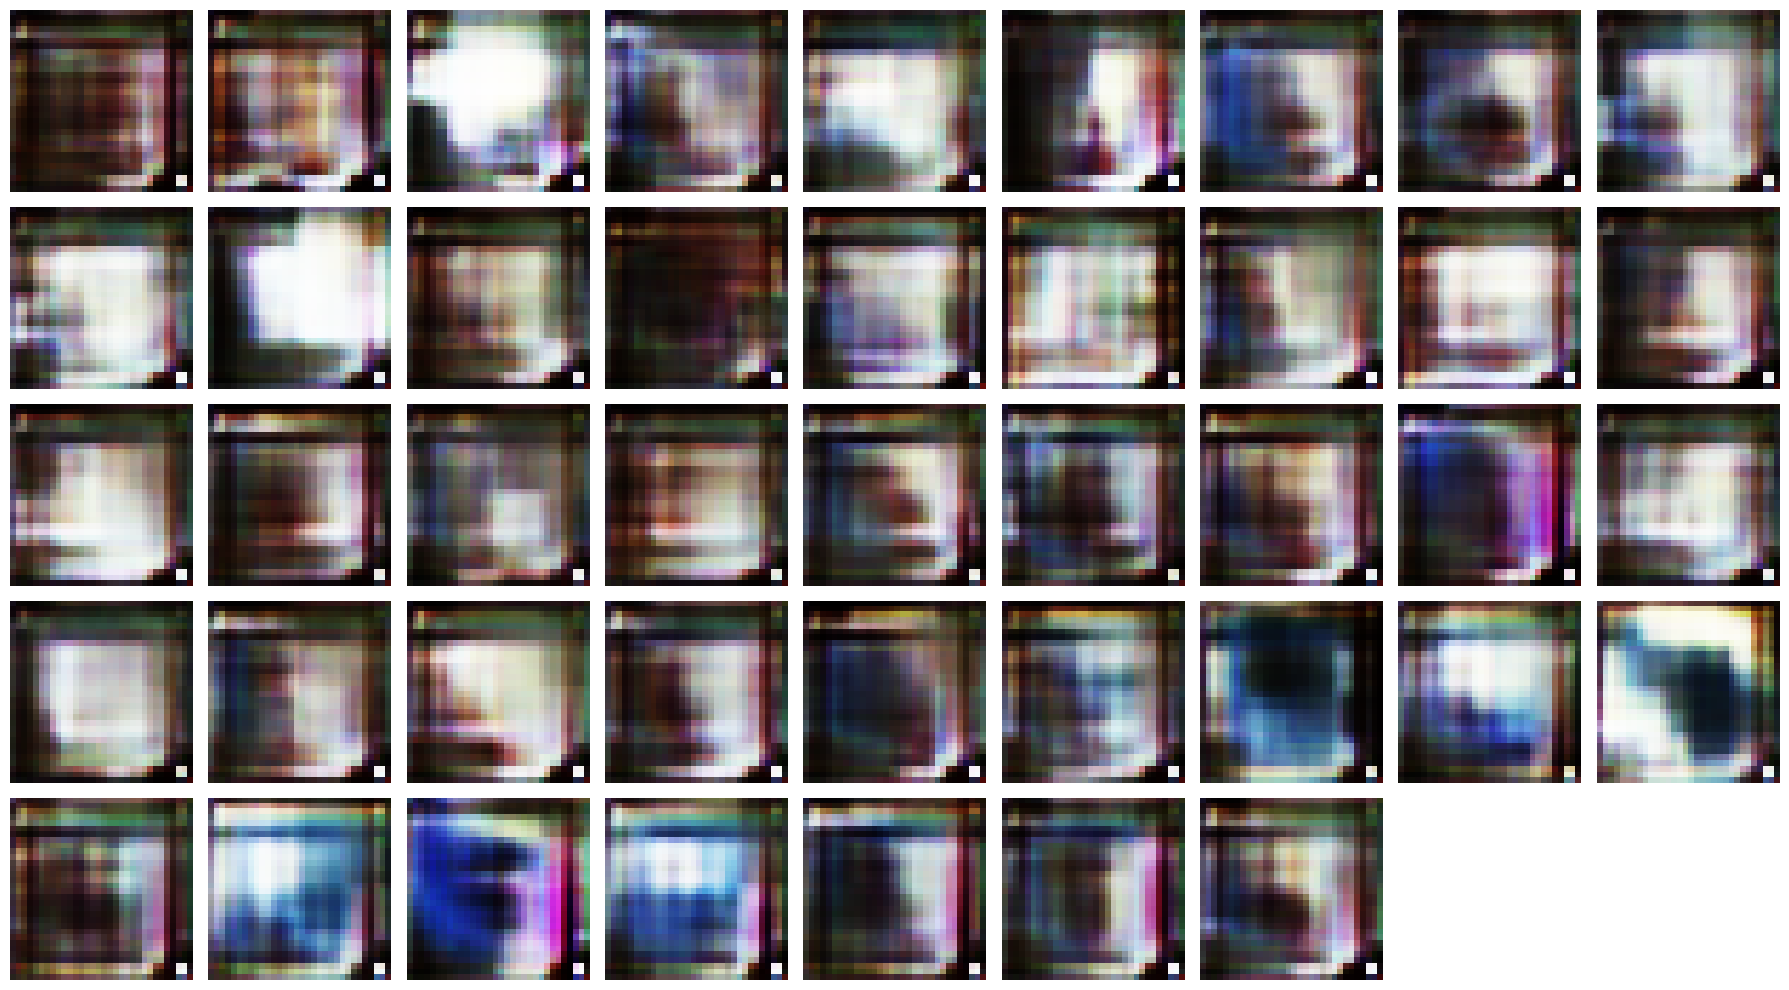

Epoch 7: 100%|██████████| 184/184 [01:06<00:00,  2.75it/s]


Epoch 7: D(real)=0.823  D(fake)=0.180  D_loss=24.529  G_loss=104.668


Epoch 8: 100%|██████████| 184/184 [01:07<00:00,  2.74it/s]


Epoch 8: D(real)=0.847  D(fake)=0.148  D_loss=15.738  G_loss=92.919


Epoch 9: 100%|██████████| 184/184 [01:07<00:00,  2.74it/s]


Epoch 9: D(real)=0.897  D(fake)=0.106  D_loss=8.851  G_loss=96.596


Epoch 10: 100%|██████████| 184/184 [01:07<00:00,  2.74it/s]


Epoch 10: D(real)=0.881  D(fake)=0.119  D_loss=11.600  G_loss=106.453


Epoch 11: 100%|██████████| 184/184 [01:06<00:00,  2.75it/s]


Epoch 11: D(real)=0.835  D(fake)=0.162  D_loss=18.430  G_loss=101.107


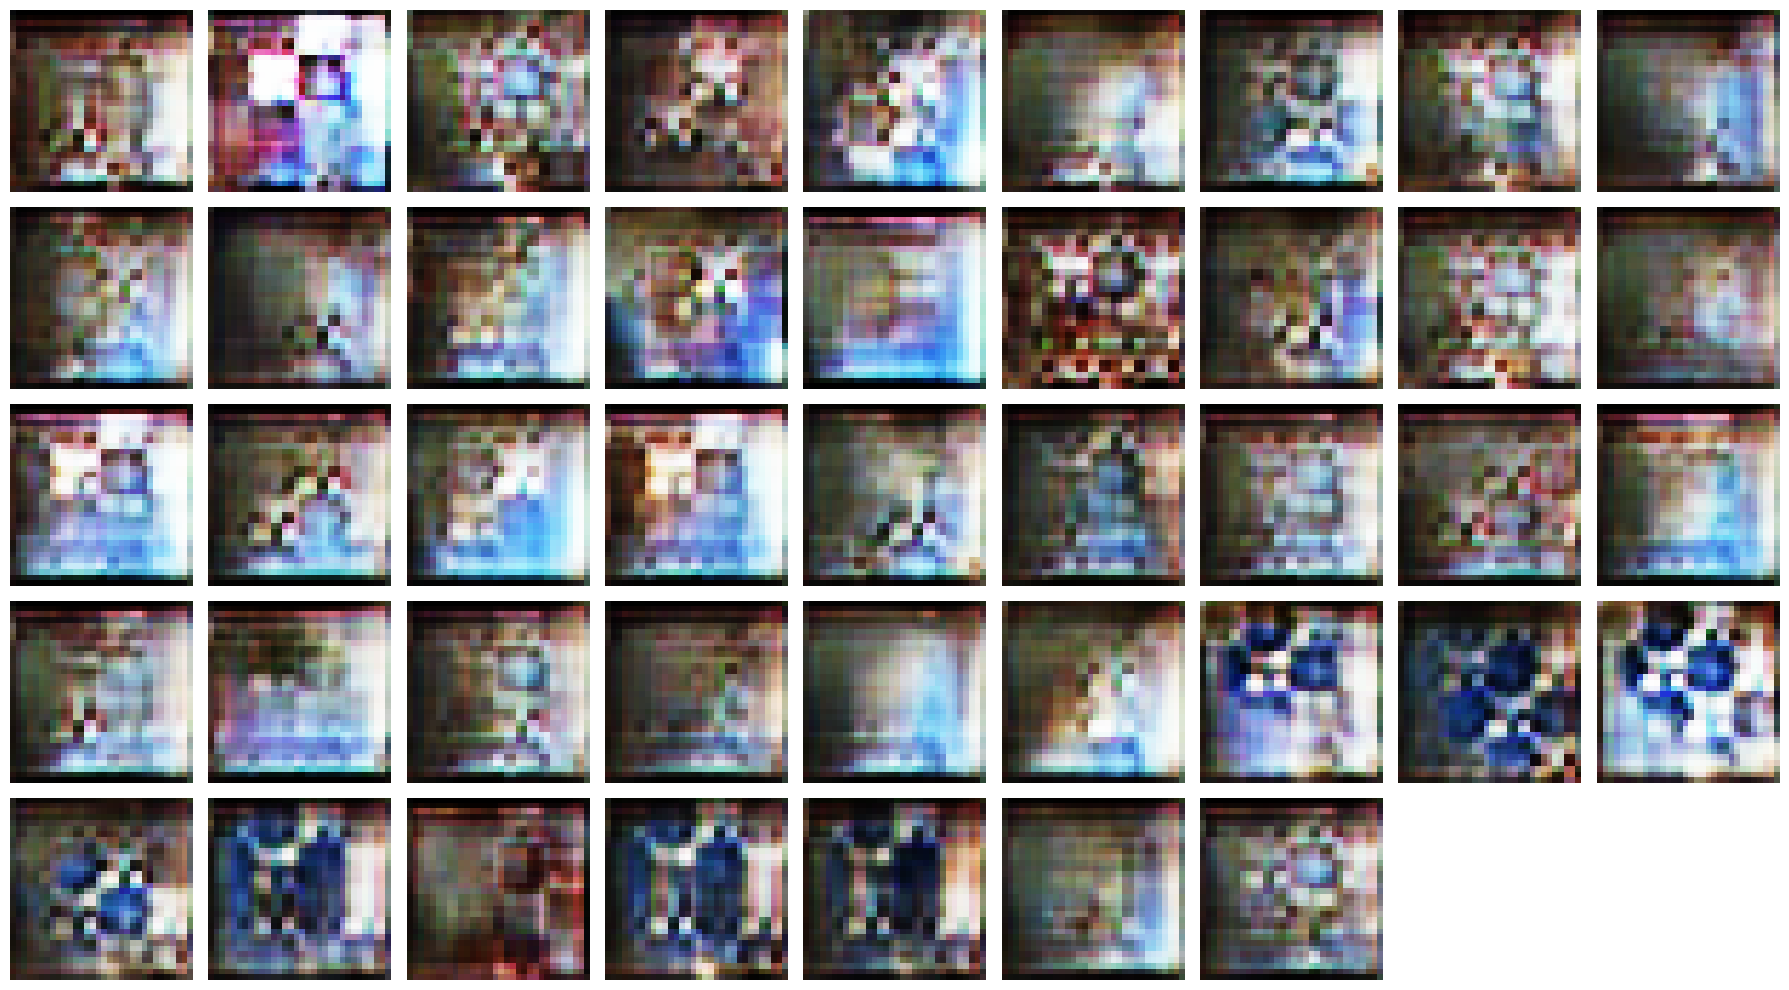

Epoch 12: 100%|██████████| 184/184 [01:06<00:00,  2.75it/s]


Epoch 12: D(real)=0.827  D(fake)=0.162  D_loss=13.499  G_loss=58.236


Epoch 13: 100%|██████████| 184/184 [01:06<00:00,  2.75it/s]


Epoch 13: D(real)=0.803  D(fake)=0.198  D_loss=20.438  G_loss=74.415


Epoch 14: 100%|██████████| 184/184 [01:07<00:00,  2.74it/s]


Epoch 14: D(real)=0.841  D(fake)=0.158  D_loss=13.002  G_loss=68.928


Epoch 15: 100%|██████████| 184/184 [01:07<00:00,  2.72it/s]


Epoch 15: D(real)=0.849  D(fake)=0.147  D_loss=10.483  G_loss=50.173


Epoch 16: 100%|██████████| 184/184 [01:07<00:00,  2.74it/s]


Epoch 16: D(real)=0.843  D(fake)=0.155  D_loss=9.438  G_loss=50.583


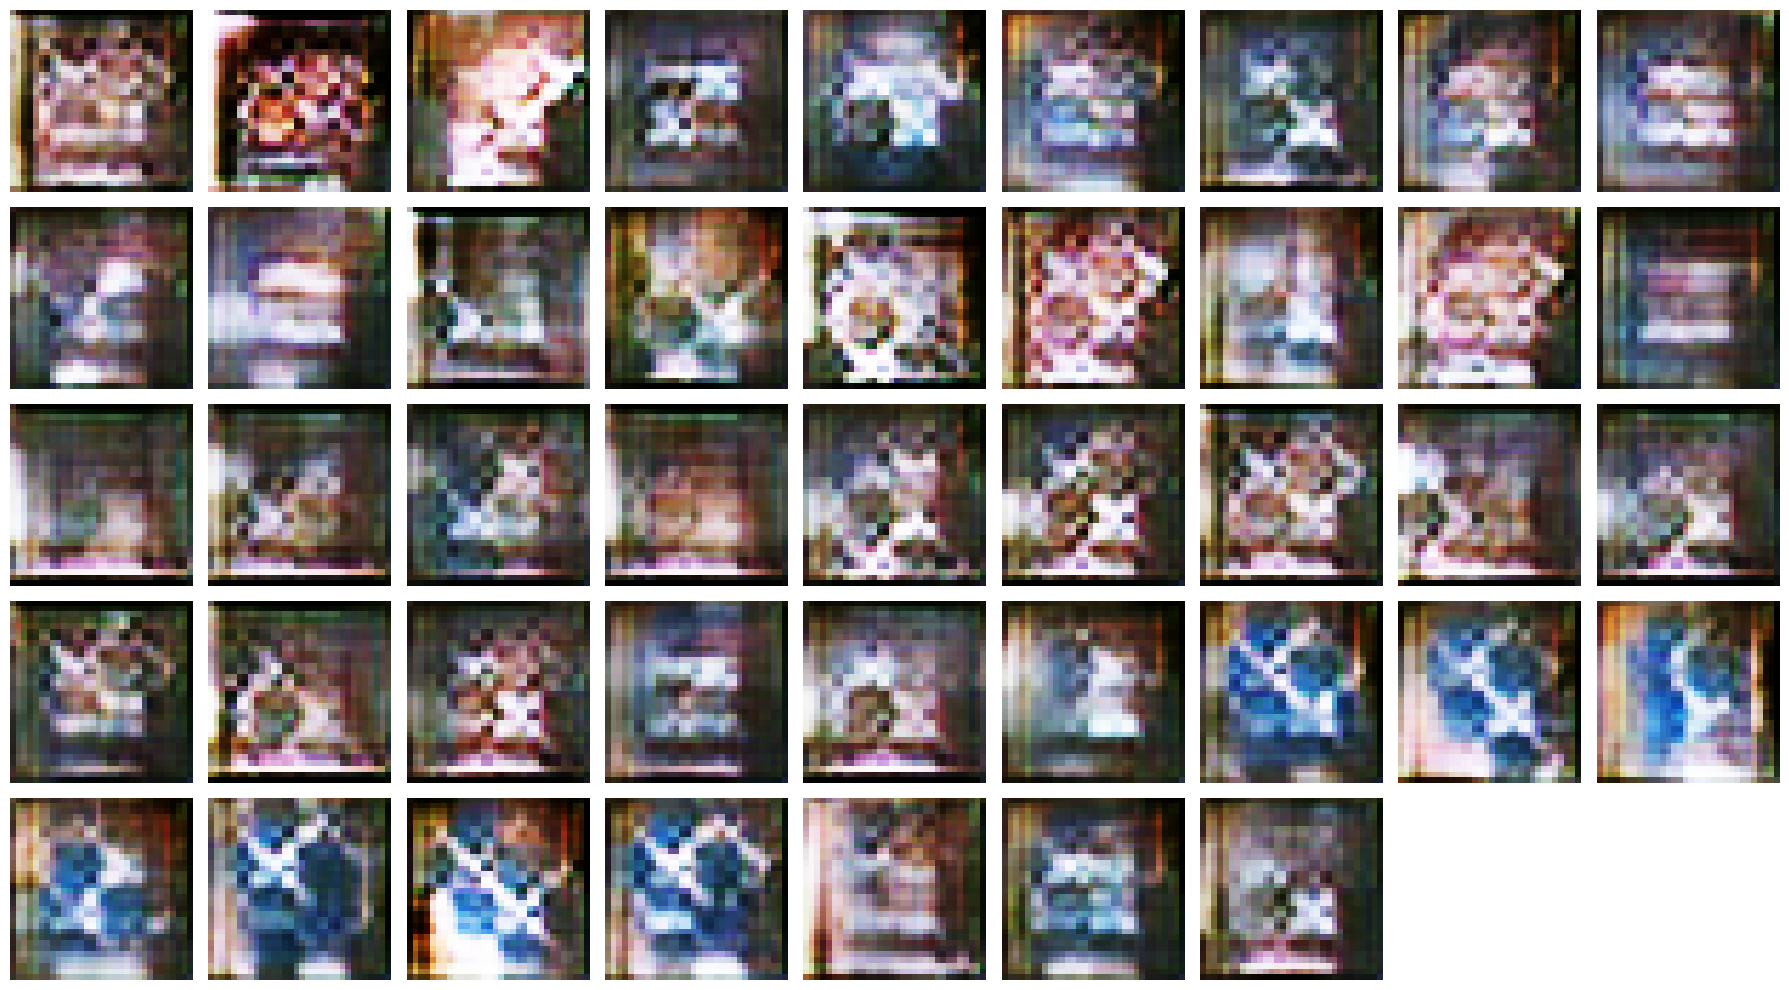

Epoch 17:  61%|██████▏   | 113/184 [00:41<00:25,  2.80it/s]

In [ ]:
from gnn import Trainer as GNNTrainer

gnn_trainer = GNNTrainer(num_classes, adversarial_criterion=adv_criterion, latent_dim=latent_dim, device=device)
gnn_trainer.set_generator(generator, generator_optimizer, generator_scheduler)
gnn_trainer.set_discriminator(discriminator, discriminator_optimizer, discriminator_scheduler)

# Training
loss = gnn_trainer.fit(rebalanced_train_dl, num_epochs=100, mean=train_mean, std=train_std)

train further

In [ ]:
loss = gnn_trainer.fit(rebalanced_train_dl, num_epochs=100, mean=train_mean, std=train_std)

save the model

In [ ]:
# Save generator and discriminator weights
import os

weights_dir = "./gnn/weights"

os.makedirs(weights_dir, exist_ok=True)

gen_path = os.path.join(weights_dir, "generator_bigger.pth")
disc_path = os.path.join(weights_dir, "discriminator_bigger.pth")

torch.save(generator.state_dict(), gen_path)
torch.save(discriminator.state_dict(), disc_path)

print(f"Generator weights saved to: {gen_path}")
print(f"Discriminator weights saved to: {disc_path}")

## Evaluation

Load test dataset

In [ ]:
test_dir = "./data/test"
test_ds = ImageFolder(test_dir)

Generate samples and save them to results folder

In [ ]:
import os
import time

from collections import Counter
from torchvision.utils import save_image


results_id = time.time()
results_dir = f"./results/{results_id}"

os.makedirs(results_dir, exist_ok=True)

class_counts = Counter(test_ds.targets)

mean_t = torch.tensor(train_mean).view(1, 3, 1, 1).to(device)
std_t = torch.tensor(train_std).view(1, 3, 1, 1).to(device)

generator.eval()

for cls, cnt in class_counts.items():
    for i in range(cnt):
        z = torch.randn(1, latent_dim, device=device)
        labels = torch.tensor([cls], device=device)
        with torch.no_grad():
            img = generator(z, labels)

        img = img * std_t + mean_t

        fname = os.path.join(results_dir, f"{cls}_{i}.jpg")
        save_image(img.clamp(0, 1), fname)

Calculate the FID between test set and generated images

In [ ]:
from pytorch_fid.fid_score import calculate_fid_given_paths

test_flat_dir = "./data/test_flat"
generated_dir = results_dir

fid = calculate_fid_given_paths([test_flat_dir, generated_dir], batch_size, device, dims=2048, num_workers=1)

print(f"FID: {fid}")